Action2	AI比赛：用户购买预测
https://aistudio.baidu.com/aistudio/competition/detail/51

数据集：train.csv 训练集，submission.csv 提交数据样例

1、提交百度AI比赛（20points）
2、月榜排名前20（20points）

# 测试集
预测下个月用户是否购买，测试集test1.csv = submission.csv

（customer_id顺序一致，result为预测结果）


# train.csv字段说明
字段	              说明
order_detail_id	    订单详情id
order_id	        订单id
order_total_num	    订单商品总购买数量
order_amount	    订单商品总金额
order_total_payment	订单实付金额
order_total_discount	订单优惠金额
order_pay_time	    付款时间
order_status	    订单状态： 1表示等待买家付款， 2表示卖家部分发货， 3表示卖家发货， 4表示等待买家确认收货， 5表示买家已签收， 6表示交易成功
order_count	        订单包含的子订单数量
is_customer_rate	用户是否评价，0没有评价，1已经评价
order_detail_status	订单详细状态
order_detail_good_num	订单中的商品数量
order_detail_amount	订单应付总金额
order_detail_payment	订单实付金额
order_detail_discount	订单优惠金额
member_id	           会员id
customer_id         	用户id
customer_gender	性别：0未知，1男，2女
customer_province	用户省份所在地
customer_city	    用户城市所在地
member_status	    会员状态：1正常，2冻结，3已删除
is_member_active	会员是否激活：0没有激活，1已激活
goods_id	        商品id
goods_class_id   	商品分类id
goods_price   	    商品原始价格
goods_status	    商品库存状态：1出售中，2库中
goods_has_discount	是否支持会员折扣：0不支持，1支持
goods_list_time	商品最新上架时间
goods_delist_time	商品最新下架时间

# submission.csv 字段说明
字段	           说明
customer_id	     用户id
result	         下个月是否会购买：0 不购买，1购买

In [1]:
import numpy as np  #
import pandas as pd  #
from datetime import datetime, date, timedelta
from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
# from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV,Ridge,Lasso,ElasticNet
# from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor,RandomForestClassifier
# from sklearn.feature_selection import mutual_info_regression
# from sklearn.svm import SVR, LinearSVC
# from sklearn.pipeline import make_pipeline,Pipeline
# from sklearn.preprocessing import RobustScaler, LabelEncoder, StandardScaler,MinMaxScaler
# from sklearn.model_selection import KFold, cross_val_score, train_test_split
# from sklearn.metrics import mean_squared_error
# from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt
import time
from itertools import product
import datetime as dt
import calendar
import gc
from datetime import date, timedelta
import paddle
import paddle.fluid as fluid
import paddle.fluid.dygraph as dygraph
from paddle.fluid.dygraph import Linear
import random

In [2]:
#据预处理
#加载数据集
PATH = './data/data19383/'
train = pd.read_csv(PATH + 'train.csv')
# train = pd.read_csv('./data/data19383/train.csv', usecols=[2, 3, 4, 6, 7, 18])
# set index to ID to avoid droping it later
# 把测试集的id列作为索引，防止误删
test  = pd.read_csv(PATH + 'submission.csv').set_index('customer_id')

In [3]:
# 对于特别大的文件，我们需要做一些内存检查
mem_train = train.memory_usage(index=True).sum()
mem_test=test.memory_usage(index=True).sum()
print(u"训练集使用内容 "+ str(mem_train/ 1024**2)+" MB")
print(u"测试集使用内存 "+ str(mem_test/ 1024**2)+" MB")

训练集使用内容 510.40096282958984 MB
测试集使用内存 24.200225830078125 MB


In [4]:
#查看数据总体分布
def summary_stats_table(data):
    '''
    a function to summerize all types of data
    分类型按列的数据分布与异常值统计
    '''
    # count of nulls
    # 空值数量
    missing_counts = pd.DataFrame(data.isnull().sum())
    missing_counts.columns = ['count_null']

    # numeric column stats
    # 数值列数据分布统计
    num_stats = data.select_dtypes(include=['int64','float64']).describe().loc[['count','min','max','25%','50%','75%']].transpose()
    num_stats['dtype'] = data.select_dtypes(include=['int64','float64']).dtypes.tolist()

    # non-numeric value stats
    # 非数值列数据分布统计
    non_num_stats = data.select_dtypes(exclude=['int64','float64']).describe().transpose()
    non_num_stats['dtype'] = data.select_dtypes(exclude=['int64','float64']).dtypes.tolist()
    non_num_stats = non_num_stats.rename(columns={"first": "min", "last": "max"})

    # merge all 
    # 聚合结果
    stats_merge = pd.concat([num_stats, non_num_stats], axis=0, join='outer', ignore_index=False, keys=None,
              levels=None, names=None, verify_integrity=False, copy=True, sort=False).fillna("").sort_values('dtype')

    column_order = ['dtype', 'count', 'count_null','unique','min','max','25%','50%','75%','top','freq']
    summary_stats = pd.merge(stats_merge, missing_counts, left_index=True, right_index=True, sort=False)[column_order]
    return(summary_stats)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2306871 entries, 0 to 2306870
Data columns (total 29 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_detail_id         int64  
 1   order_id                int64  
 2   order_total_num         float64
 3   order_amount            float64
 4   order_total_payment     float64
 5   order_total_discount    float64
 6   order_pay_time          object 
 7   order_status            int64  
 8   order_count             float64
 9   is_customer_rate        float64
 10  order_detail_status     float64
 11  order_detail_goods_num  float64
 12  order_detail_amount     float64
 13  order_detail_payment    float64
 14  order_detail_discount   float64
 15  customer_province       object 
 16  customer_city           object 
 17  member_id               float64
 18  customer_id             int64  
 19  customer_gender         float64
 20  member_status           float64
 21  is_member_actived       float64

In [5]:
summary_stats_table(train)

,dtype,count,count_null,unique,min,max,25%,50%,75%,top,freq
order_detail_id,int64,2306871.0,0,,1e+06,3.6855e+06,1.66968e+06,2.33935e+06,3.00743e+06,,
order_id,int64,2306871.0,0,,1e+06,3.23836e+06,1.57148e+06,2.14299e+06,2.70795e+06,,
goods_class_id,int64,2306871.0,0,,998,6673,1038,1233,1643,,
order_status,int64,2306871.0,0,,0,101,6,6,6,,
goods_id,int64,2306871.0,0,,998,6673,1038,1233,1643,,
customer_id,int64,2306871.0,0,,1e+06,2.82657e+06,1.43643e+06,1.92957e+06,2.45782e+06,,
goods_has_discount,float64,2306871.0,0,,0,1,0,0,0,,
goods_status,float64,2306871.0,0,,0,2,1,1,1,,
goods_price,float64,2306435.0,436,,-79.9748,92.3526,49.6004,53.9093,54.8506,,
is_member_actived,float64,635790.0,1671081,,1,1,1,1,1,,


In [6]:
# 训练集概况
train[['order_detail_id','order_id','order_amount','order_pay_time','is_customer_rate','order_detail_goods_num','order_detail_amount','order_detail_discount','customer_id','goods_id']].tail(10)

,order_detail_id,order_id,order_amount,order_pay_time,is_customer_rate,order_detail_goods_num,order_detail_amount,order_detail_discount,customer_id,goods_id
2306861,3685490,3238357,707.7,2013-01-24 00:24:40,0.0,2.0,179.8,298.2,2826572,1478
2306862,3685491,3238356,775.9,2012-11-11 17:35:05,0.0,1.0,126.9,172.1,2826572,2103
2306863,3685492,3238357,707.7,2013-01-24 00:24:40,0.0,1.0,0.0,29.9,2826572,3153
2306864,3685493,3238356,775.9,2012-11-11 17:35:05,0.0,1.0,74.9,105.0,2826572,1778
2306865,3685494,3238357,707.7,2013-01-24 00:24:40,0.0,1.0,94.9,104.9,2826572,2128
2306866,3685495,3238358,199.0,2013-01-10 19:24:31,0.0,1.0,59.9,139.1,2826573,1173
2306867,3685496,3238359,299.8,2013-01-27 15:00:27,0.0,1.0,0.0,59.9,2826574,2513
2306868,3685497,3238359,299.8,2013-01-27 15:00:27,0.0,1.0,89.9,150.0,2826574,998
2306869,3685498,3238360,168.0,2012-11-11 00:10:37,0.0,1.0,76.9,91.1,2826574,1423
2306870,3685499,3238361,102.0,2013-07-10 14:22:14,0.0,1.0,49.9,52.1,2826574,1043


In [7]:
len(test)

1585986

In [8]:
len(train['customer_id'][train.order_pay_time>'2013-07-31'].unique())

174770

In [9]:
len(train[train.order_pay_time<'2013-07-31'])

2078390

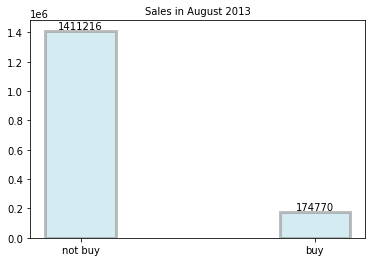

In [10]:
%matplotlib inline
y = range(1,2)
 
plt.bar(['not buy','buy'], [1585986-174770,174770], alpha=0.5, width=0.3, color='lightblue', edgecolor='grey', lw=3)
plt.title('Sales in August 2013', fontsize=10)
for a, b in zip(['not buy','buy'], [1585986-174770,174770]):
    plt.text(a, b + 0.05, '%.0f' % b, ha='center', va='bottom', fontsize=10)
plt.show()

# 内存优化脚本
参考缓解pandas中DataFrame占用内存过大的问题
效果非常显著，有效避免内存溢出

In [11]:
# @from: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65/code
# @liscense: Apache 2.0
# @author: weijian
def reduce_mem_usage(props):
    # 计算当前内存
    start_mem_usg = props.memory_usage().sum() / 1024 ** 2
    print("Memory usage of the dataframe is :", start_mem_usg, "MB")
    
    # 哪些列包含空值，空值用-999填充。why：因为np.nan当做float处理
    NAlist = []
    for col in props.columns:
        # 这里只过滤了objectd格式，如果你的代码中还包含其他类型，请一并过滤
        if (props[col].dtypes != object):
            
            # print("**************************")
            # print("columns: ", col)
            # print("dtype before", props[col].dtype)
            
            # 判断是否是int类型
            isInt = False
            mmax = props[col].max()
            mmin = props[col].min()
            
            # Integer does not support NA, therefore Na needs to be filled
            if not np.isfinite(props[col]).all():
                NAlist.append(col)
                props[col].fillna(-999, inplace=True) # 用-999填充
                
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = np.fabs(props[col] - asint)
            result = result.sum()
            if result < 0.01: # 绝对误差和小于0.01认为可以转换的，要根据task修改
                isInt = True
            
            # make interger / unsigned Integer datatypes
            if isInt:
                if mmin >= 0: # 最小值大于0，转换成无符号整型
                    if mmax <= 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mmax <= 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mmax <= 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else: # 转换成有符号整型
                    if mmin > np.iinfo(np.int8).min and mmax < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mmin > np.iinfo(np.int16).min and mmax < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mmin > np.iinfo(np.int32).min and mmax < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mmin > np.iinfo(np.int64).min and mmax < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)  
            else: # 注意：这里对于float都转换成float16，需要根据你的情况自己更改
                props[col] = props[col].astype(np.float16)
            
            # print("dtype after", props[col].dtype)
            # print("********************************")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

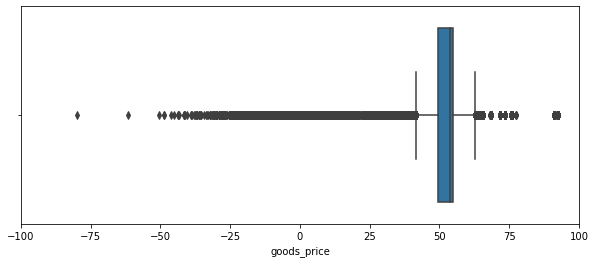

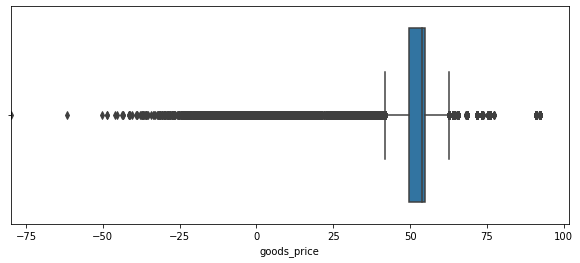

In [12]:
plt.figure(figsize=(10,4))
# x轴坐标范围
plt.xlim(-100, 100)
sns.boxplot(x=train.goods_price)

plt.figure(figsize=(10,4))
# x轴坐标范围
plt.xlim(train.goods_price.min(), train.goods_price.max()*1.1)
sns.boxplot(x=train.goods_price)

In [13]:
train[train.goods_price<0].head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
2312,1003841,1003239,1.0,0.01,0.01,0.0,2013-05-12 20:21:07,6,1.0,0.0,...,NaN,NaN,NaN,2538,2538,-12.965136,1.0,0.0,2014-10-28 09:43:51,2014-11-04 09:43:51
2523,1004052,1003440,1.0,0.01,0.01,0.0,2013-04-22 10:22:39,6,1.0,0.0,...,NaN,NaN,NaN,2538,2538,-9.717323,1.0,0.0,2014-10-28 09:43:51,2014-11-04 09:43:51
2822,1004351,1003720,23.0,23.00,23.00,0.0,2013-04-03 21:40:50,6,1.0,0.0,...,NaN,NaN,NaN,1768,1768,-0.334533,1.0,0.0,2014-10-28 11:30:18,2014-11-04 11:30:18
5203,1006732,1005821,1.0,1.00,1.00,0.0,2013-01-24 22:00:31,6,1.0,0.0,...,NaN,NaN,NaN,3098,3098,-16.420158,2.0,0.0,2014-01-10 15:47:52,2014-01-11 12:46:23
6193,1007722,1006556,1.0,1.00,1.00,0.0,2013-01-09 14:13:06,6,1.0,0.0,...,NaN,NaN,NaN,3278,3278,-7.076659,2.0,0.0,2013-01-09 14:00:00,2013-01-09 14:00:06


In [14]:
train[train.goods_id==3098].head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,customer_gender,member_status,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time
4595,1006124,1005323,1.0,1.0,1.0,0.0,2013-01-28 23:01:23,6,1.0,0.0,...,NaN,NaN,NaN,3098,3098,6.200496,2.0,0.0,2014-01-10 15:47:52,2014-01-11 12:46:23
5203,1006732,1005821,1.0,1.0,1.0,0.0,2013-01-24 22:00:31,6,1.0,0.0,...,NaN,NaN,NaN,3098,3098,-16.420158,2.0,0.0,2014-01-10 15:47:52,2014-01-11 12:46:23
14134,1017231,1014834,1.0,1.0,1.0,0.0,2013-01-28 23:01:01,6,1.0,0.0,...,NaN,NaN,NaN,3098,3098,-4.398973,2.0,0.0,2014-01-10 15:47:52,2014-01-11 12:46:23
23704,1028271,1024252,1.0,1.0,1.0,0.0,2013-01-28 23:01:02,6,1.0,0.0,...,NaN,NaN,NaN,3098,3098,9.244595,2.0,0.0,2014-01-10 15:47:52,2014-01-11 12:46:23
33430,1039528,1033850,1.0,1.0,1.0,0.0,2013-01-28 23:01:56,6,1.0,0.0,...,NaN,NaN,NaN,3098,3098,-29.069258,2.0,0.0,2014-01-10 15:47:52,2014-01-11 12:46:23


In [15]:
#中文id映射
train['customer_city_id'] = LabelEncoder().fit_transform(train['customer_city'].astype(str))
train['customer_province_id'] = LabelEncoder().fit_transform(train['customer_province'].astype(str))
# 处理id字段
train['order_detail_id'] = train['order_detail_id'].astype(np.uint32)
train['order_id'] = train['order_id'].astype(np.uint32)
train['customer_id'] = train['customer_id'].astype(np.uint32)
train['goods_id'] = train['goods_id'].astype(np.uint32)
train['goods_class_id'] = train['goods_class_id'].astype(np.uint32)
train['member_id'] = train['member_id'].astype(np.uint32)
# 处理状态字段，这里同时处理空值，将空值置为0
train['order_status'] = train['order_status'].astype(np.uint8)
train['goods_has_discount'] = train['goods_has_discount'].astype(np.uint8)
train["is_member_actived"].fillna(0, inplace=True)
train["is_member_actived"]=train["is_member_actived"].astype(np.int8)
train["member_status"].fillna(0, inplace=True)
train["member_status"]=train["member_status"].astype(np.int8)
train["customer_gender"].fillna(0, inplace=True)
train["customer_gender"]=train["customer_gender"].astype(np.int8)
train['is_customer_rate'] = train['is_customer_rate'].astype(np.uint8)
train['order_detail_status'] = train['order_detail_status'].astype(np.uint8)
# 处理日期
train['goods_list_time']=pd.to_datetime(train['goods_list_time'],format="%Y-%m-%d")
train['order_pay_time']=pd.to_datetime(train['order_pay_time'],format="%Y-%m-%d")
train['goods_delist_time']=pd.to_datetime(train['goods_delist_time'],format="%Y-%m-%d")
# 检查内存使用
mem_train = train.memory_usage(index=True).sum()
mem_test=test.memory_usage(index=True).sum()
print(u"训练集使用内容 "+ str(mem_train/ 1024**2)+" MB")
print(u"测试集使用内存 "+ str(mem_test/ 1024**2)+" MB")

训练集使用内容 367.4007272720337 MB
测试集使用内存 24.200225830078125 MB


In [16]:
train.head()

,order_detail_id,order_id,order_total_num,order_amount,order_total_payment,order_total_discount,order_pay_time,order_status,order_count,is_customer_rate,...,is_member_actived,goods_id,goods_class_id,goods_price,goods_status,goods_has_discount,goods_list_time,goods_delist_time,customer_city_id,customer_province_id
0,1000000,1000000,1.0,239.9,96.9,0.0,2012-11-01 00:10:56,6,1.0,0,...,0,998,998,54.909289,1.0,0,2014-10-25 11:08:07,2014-11-01 11:08:07,53,4
1,1001530,1001327,2.0,288.0,96.9,0.0,2013-08-31 23:14:42,6,2.0,0,...,0,1953,1953,45.961352,0.0,1,2013-08-28 17:27:50,2013-09-01 00:38:17,322,3
2,1001531,1001327,2.0,288.0,96.9,0.0,2013-08-31 23:14:42,6,2.0,0,...,0,1083,1083,53.035439,1.0,0,2014-10-29 18:21:05,2014-11-05 18:21:05,322,3
3,1001532,1001328,3.0,180.0,89.7,0.0,2013-08-31 22:06:35,6,1.0,0,...,0,1013,1013,46.046917,1.0,1,2014-10-25 11:00:00,2014-11-01 11:00:00,185,20
4,1001533,1001329,1.0,159.9,65.9,0.0,2013-08-31 21:33:36,6,1.0,0,...,0,1628,1628,50.722161,1.0,0,2014-10-23 15:35:33,2014-10-30 15:35:33,53,4


# 构造时间滑窗特征
训练集 训练日期截止分别为2013.6.6、2013.6.20、2013.7.1、2013.7.15 标签为训练截止日期开始的30天有没有下过单 标签通过切片的形式构造 把4个部分训练集拼起来 验证集 验证数据到2013.8.1 标签为2013.8.1开始的30天有没有下过单 标签时间2013.8.1-2013.8.30 测试集 测试数据到2013.8.31 没有标签

In [17]:
#每日付款金额
# 将用户下单金额按天进行汇总
df = train[train.order_pay_time>'2013-02-01']
df['date'] = pd.DatetimeIndex(df['order_pay_time']).date
df_payment = df[['customer_id','date','order_total_payment']]

<ipython-input-17-45eb80d39d53>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = pd.DatetimeIndex(df['order_pay_time']).date


In [18]:
len(df_payment['customer_id'].unique())

685471

注意，成功交易的客户数量不等于全部客户数量，说明有相当一部分客户虽然下过单，
但是没有成功的订单，那么这些客户自然应当算在训练集之外。 数据合并时，
由于test.csv中，已经设置了默认0值，只需要和训练后的预测标签做一个left join就可以了

In [19]:
df_payment = df_payment.groupby(['date','customer_id']).agg({'order_total_payment': ['sum']})
df_payment.columns = ['day_total_payment']
df_payment.reset_index(inplace=True)

In [20]:

df_payment = df_payment.set_index(
    ["customer_id", "date"])[["day_total_payment"]].unstack(level=-1).fillna(0)
df_payment.columns = df_payment.columns.get_level_values(1)

In [21]:
#每日购买商品数量
df_goods = df[['customer_id','date','order_total_num']]
df_goods = df_goods.groupby(['date','customer_id']).agg({'order_total_num': ['sum']})
df_goods.columns = ['day_total_num']
df_goods.reset_index(inplace=True)
df_goods = df_goods.set_index(
    ["customer_id", "date"])[["day_total_num"]].unstack(level=-1).fillna(0)
df_goods.columns = df_goods.columns.get_level_values(1)

In [22]:
#该场景每天都有成交记录，这样就不需要考虑生成完整时间段填充的问题
# 这是一个时间滑窗函数，获得dt之前minus天以来periods的dataframe，以便进一步计算
def get_timespan(df, dt, minus, periods, freq='D'):
    return df[pd.date_range(dt - timedelta(days=minus), periods=periods, freq=freq)]

1.构造dataset这里有个取巧的地方，因为要预测的9月份除了开学季以外不是非常特殊的月份，因此主要考虑近期的因素，数据集的开始时间也是2月1日，尽量避免了双十一、元旦假期的影响，当然春节假期继续保留。同时，构造数据集的时候保留了customer_id，主要为了与其它特征做整合。

2.通过一个函数整合付款金额和商品数量的时间滑窗，主要是因为分开做到时候合并占用内存更大，并且函数最后在返回值处做了内存优化，用时间代价尽可能避免内存溢出。

In [23]:
def prepare_dataset(df_payment, df_goods, t2018, is_train=True):
    X = {}
    # 整合用户id
    tmp = df_payment.reset_index()
    X['customer_id'] = tmp['customer_id']
    # 消费特征
    print('Preparing payment feature...')
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018, i, i)
        # X['diff_%s_mean' % i] = tmp_1.diff(axis=1).mean(axis=1).values
        X['mean_%s_decay' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        # X['mean_%s' % i] = tmp_1.mean(axis=1).values
        # X['median_%s' % i] = tmp.median(axis=1).values
        # X['min_%s' % i] = tmp_1.min(axis=1).values
        X['max_%s' % i] = tmp.max(axis=1).values
        # X['std_%s' % i] = tmp_1.std(axis=1).values
        X['sum_%s' % i] = tmp.sum(axis=1).values
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018 + timedelta(days=-7), i, i)
        X['mean_%s_decay_2' % i] = (tmp * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
        # X['mean_%s_2' % i] = tmp_2.mean(axis=1).values
        # X['median_%s_2' % i] = tmp.median(axis=1).values
        # X['min_%s_2' % i] = tmp_2.min(axis=1).values
        X['max_%s_2' % i] = tmp.max(axis=1).values
        # X['std_%s_2' % i] = tmp_2.std(axis=1).values
    for i in [14,30,60,91]:
        tmp = get_timespan(df_payment, t2018, i, i)
        X['has_sales_days_in_last_%s' % i] = (tmp != 0).sum(axis=1).values
        X['last_has_sales_day_in_last_%s' % i] = i - ((tmp != 0) * np.arange(i)).max(axis=1).values
        X['first_has_sales_day_in_last_%s' % i] = ((tmp != 0) * np.arange(i, 0, -1)).max(axis=1).values
        
        # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['day_%s_2018' % i] = get_timespan(df_payment, t2018, i*30, 30).sum(axis=1).values
    # 商品数量特征，这里故意把时间和消费特征错开，提高时间滑窗的覆盖面
    print('Preparing num feature...')
    for i in [21,49,84]:
            tmp = get_timespan(df_goods, t2018, i, i)
            # X['goods_diff_%s_mean' % i] = tmp_1.diff(axis=1).mean(axis=1).values
            # X['goods_mean_%s_decay' % i] = (tmp_1 * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
            X['goods_mean_%s' % i] = tmp.mean(axis=1).values
            # X['goods_median_%s' % i] = tmp.median(axis=1).values
            # X['goods_min_%s' % i] = tmp_1.min(axis=1).values
            X['goods_max_%s' % i] = tmp.max(axis=1).values
            # X['goods_std_%s' % i] = tmp_1.std(axis=1).values
            X['goods_sum_%s' % i] = tmp.sum(axis=1).values
    for i in [21,49,84]:    
            tmp = get_timespan(df_goods, t2018 + timedelta(weeks=-1), i, i)
            # X['goods_diff_%s_mean_2' % i] = tmp_2.diff(axis=1).mean(axis=1).values
            # X['goods_mean_%s_decay_2' % i] = (tmp_2 * np.power(0.9, np.arange(i)[::-1])).sum(axis=1).values
            X['goods_mean_%s_2' % i] = tmp.mean(axis=1).values
            # X['goods_median_%s_2' % i] = tmp.median(axis=1).values
            # X['goods_min_%s_2' % i] = tmp_2.min(axis=1).values
            X['goods_max_%s_2' % i] = tmp.max(axis=1).values
            X['goods_sum_%s_2' % i] = tmp.sum(axis=1).values
    for i in [21,49,84]:    
            tmp = get_timespan(df_goods, t2018, i, i)
            X['goods_has_sales_days_in_last_%s' % i] = (tmp > 0).sum(axis=1).values
            X['goods_last_has_sales_day_in_last_%s' % i] = i - ((tmp > 0) * np.arange(i)).max(axis=1).values
            X['goods_first_has_sales_day_in_last_%s' % i] = ((tmp > 0) * np.arange(i, 0, -1)).max(axis=1).values


    # 对此处进行微调，主要考虑近期因素
    for i in range(1, 4):
        X['goods_day_%s_2018' % i] = get_timespan(df_goods, t2018, i*28, 28).sum(axis=1).values

    X = pd.DataFrame(X)
    
    reduce_mem_usage(X)
    
    if is_train:
        # 这样转换之后，打标签直接用numpy切片就可以了
        # 当然这里前提是确认付款总额没有负数的问题
        X['label'] = df_goods[pd.date_range(t2018, periods=30)].max(axis=1).values
        X['label'][X['label'] > 0] = 1
        return X
    return X

In [24]:
num_days = 4
t2017 = date(2013, 7, 1)
X_l, y_l = [], []
for i in range(num_days):
    delta = timedelta(days=7 * i)
    # X_tmp, y_tmp = prepare_dataset(df_payment, df_goods, t2017 + delta)
    X_tmp = prepare_dataset(df_payment, df_goods, t2017 + delta)
    X_tmp = pd.concat([X_tmp], axis=1)

    X_l.append(X_tmp)
    # y_l.append(y_tmp)

X_train = pd.concat(X_l, axis=0)
# y_train = np.concatenate(y_l, axis=0)

del X_l, y_l

Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 308.55411529541016 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  23.94070805672356 % of the initial size


<ipython-input-23-9018492b22cf>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['label'][X['label'] > 0] = 1


Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 308.55411529541016 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  23.94070805672356 % of the initial size


<ipython-input-23-9018492b22cf>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['label'][X['label'] > 0] = 1


Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 308.55411529541016 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  23.94070805672356 % of the initial size


<ipython-input-23-9018492b22cf>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['label'][X['label'] > 0] = 1


Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 308.55411529541016 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  23.94070805672356 % of the initial size


<ipython-input-23-9018492b22cf>:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['label'][X['label'] > 0] = 1


In [25]:
X_test = prepare_dataset(df_payment, df_goods, date(2013, 9, 1), is_train=False)
X_test = pd.concat([X_test], axis=1)

Preparing payment feature...
Preparing num feature...
Memory usage of the dataframe is : 308.55411529541016 MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  73.87003993988037  MB
This is  23.94070805672356 % of the initial size


In [26]:
#中间结果保存
X_train.to_csv('X_train.csv')

In [27]:
X_test.to_csv('X_test.csv')

# 选取参与训练的特征

In [28]:
#加载特征工程的结果
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
customer_id = X_test["customer_id"].values.tolist()
X_train.drop(['Unnamed: 0','customer_id'], inplace=True, axis=1)
X_test.drop(['Unnamed: 0','customer_id'], inplace=True, axis=1)

In [29]:
X_train.head()

,mean_14_decay,max_14,sum_14,mean_30_decay,max_30,sum_30,mean_60_decay,max_60,sum_60,mean_91_decay,...,goods_has_sales_days_in_last_49,goods_last_has_sales_day_in_last_49,goods_first_has_sales_day_in_last_49,goods_has_sales_days_in_last_84,goods_last_has_sales_day_in_last_84,goods_first_has_sales_day_in_last_84,goods_day_1_2018,goods_day_2_2018,goods_day_3_2018,label
0,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0,49,0,0,84,0,0,0,0,0.0
1,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0,49,0,0,84,0,0,0,0,0.0
2,0.0,0.0,0.0,3.537,39.9,39.9,3.537,39.9,39.9,3.537,...,1,24,24,1,24,24,1,0,0,0.0
3,0.0,0.0,0.0,0.000,0.0,0.0,0.000,0.0,0.0,0.000,...,0,49,0,0,84,0,0,0,0,1.0
4,0.0,0.0,0.0,0.000,0.0,0.0,2.530,98.9,197.8,2.530,...,1,37,37,2,37,56,0,2,0,1.0


In [30]:
#选取参与训练的特征
print(X_train.columns)

Index(['mean_14_decay', 'max_14', 'sum_14', 'mean_30_decay', 'max_30',
       'sum_30', 'mean_60_decay', 'max_60', 'sum_60', 'mean_91_decay',
       'max_91', 'sum_91', 'mean_14_decay_2', 'max_14_2', 'mean_30_decay_2',
       'max_30_2', 'mean_60_decay_2', 'max_60_2', 'mean_91_decay_2',
       'max_91_2', 'has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91',
       'first_has_sales_day_in_last_91', 'day_1_2018', 'day_2_2018',
       'day_3_2018', 'goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21

In [31]:
X_train = X_train[['has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91','goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21_2', 'goods_mean_49_2', 'goods_max_49_2', 'goods_sum_49_2',
       'goods_mean_84_2', 'goods_max_84_2', 'goods_sum_84_2',
       'goods_has_sales_days_in_last_21',
       'goods_last_has_sales_day_in_last_21',
       'goods_first_has_sales_day_in_last_21',
       'goods_has_sales_days_in_last_49',
       'goods_last_has_sales_day_in_last_49',
       'goods_first_has_sales_day_in_last_49',
       'goods_has_sales_days_in_last_84',
       'goods_last_has_sales_day_in_last_84',
       'goods_first_has_sales_day_in_last_84', 'goods_day_1_2018',
       'goods_day_2_2018', 'goods_day_3_2018','label']]
X_test = X_test[['has_sales_days_in_last_14',
       'last_has_sales_day_in_last_14', 'first_has_sales_day_in_last_14',
       'has_sales_days_in_last_30', 'last_has_sales_day_in_last_30',
       'first_has_sales_day_in_last_30', 'has_sales_days_in_last_60',
       'last_has_sales_day_in_last_60', 'first_has_sales_day_in_last_60',
       'has_sales_days_in_last_91', 'last_has_sales_day_in_last_91','goods_mean_21', 'goods_max_21', 'goods_sum_21',
       'goods_mean_49', 'goods_max_49', 'goods_sum_49', 'goods_mean_84',
       'goods_max_84', 'goods_sum_84', 'goods_mean_21_2', 'goods_max_21_2',
       'goods_sum_21_2', 'goods_mean_49_2', 'goods_max_49_2', 'goods_sum_49_2',
       'goods_mean_84_2', 'goods_max_84_2', 'goods_sum_84_2',
       'goods_has_sales_days_in_last_21',
       'goods_last_has_sales_day_in_last_21',
       'goods_first_has_sales_day_in_last_21',
       'goods_has_sales_days_in_last_49',
       'goods_last_has_sales_day_in_last_49',
       'goods_first_has_sales_day_in_last_49',
       'goods_has_sales_days_in_last_84',
       'goods_last_has_sales_day_in_last_84',
       'goods_first_has_sales_day_in_last_84', 'goods_day_1_2018',
       'goods_day_2_2018', 'goods_day_3_2018']]

In [32]:
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# 数据归一化

In [33]:
X_train = (X_train - X_train.min()) / (X_train.max() - X_train.min())
X_test = (X_test - X_test.min()) / (X_test.max() - X_test.min())

In [34]:
# 前面标签也被归一化了，还原
X_train['label'][X_train['label'] > 0] = 1

In [35]:
print(len(X_train.columns))

42


In [36]:
# 数据分割
def load_data(df,istrain):
    # data = np.fromfile(datafile)
    data = df

    feature_num = len(data.columns)
    # 将原始数据进行Reshape
    data = np.array(data)
    data = data.reshape([-1, feature_num])
    
    # 训练集和测试集的划分比例
    #ratio = 0.8
    if istrain == True:
        ratio = 0.8
        offset = int(data.shape[0] * ratio)
        training_data = data[:offset]
        test_data = data[offset:]
    else:
        training_data = data
        test_data = None

    return training_data, test_data

In [37]:
# 加载处理后的数据
training_data, test_data = load_data(X_train,True)
print('train set done.')

pre_data, none = load_data(X_test,False)
print('test set done.')

train set done.
test set done.


# 搭建多层神经网络

In [38]:
# 构建多层神经网络
class Regressor(fluid.dygraph.Layer):
    def __init__(self, name_scope):
        super(Regressor, self).__init__(name_scope)
        name_scope = self.full_name()
        # 定义三层全连接层，输出维度是1，激活函数为relu
        self.fc1 = Linear(input_dim=41, output_dim=128, act='relu') # 输入层，input dim 为数据维度大小
        self.fc2 = Linear(input_dim=128, output_dim=128, act='relu')
        self.fc3 = Linear(input_dim=128, output_dim=1, act='sigmoid')
    # 网络的前向计算函数
    def forward(self, inputs):
        fc1 = self.fc1(inputs)
        fc2 = self.fc2(fc1)
        x = self.fc3(fc2)
        return x

In [39]:
with fluid.dygraph.guard():
    # 声明定义好的线性回归模型
    model = Regressor("Regressor")
    # 开启模型训练模式
    model.train()
    # 定义优化算法，这里使用Adam Optimizer
    # 学习率设置为0.00001
    opt = fluid.optimizer.Adam(learning_rate=0.00001, parameter_list=model.parameters())

In [40]:
# 定义损失函数

In [41]:
# 使用类别权重对数据不平衡问题进行处理
def wce_loss(pred, label, w=48, epsilon=1e-05): # w 是给到 y=1 类别的权重，越大越重视
    label = fluid.layers.clip(label, epsilon, 1-epsilon)
    pred = fluid.layers.clip(pred, epsilon, 1-epsilon)

    loss = -1 * (w * label * fluid.layers.log(pred) + (1 - label) * fluid.layers.log(1 - pred))
    loss = fluid.layers.reduce_mean(loss)
    return loss

In [42]:
# 开始训练

In [43]:
# 模型训练和保存
with dygraph.guard(fluid.CPUPlace()):
    EPOCH_NUM = 10   # 设置外层循环次数
    BATCH_SIZE = 4096  # 设置batch大小
    
    # 定义外层循环
    for epoch_id in range(EPOCH_NUM):
        # 在每轮迭代开始之前，将训练数据的顺序随机的打乱
        np.random.shuffle(training_data)
        # 将训练数据进行拆分
        mini_batches = [training_data[k:k+BATCH_SIZE] for k in range(0, len(training_data), BATCH_SIZE)]
        
        # 定义内层循环
        for iter_id, mini_batch in enumerate(mini_batches):
            x = np.array(mini_batch[:, :-1]).astype('float32') # 获得当前批次训练数据
            y = np.array(mini_batch[:, -1:]).astype('float32') # 获得当前批次训练标签

            # 将numpy数据转为飞桨动态图variable形式
            buyer_features = dygraph.to_variable(x)
            result = dygraph.to_variable(y)
            
            # 前向计算
            predicts = model(buyer_features)
            # loss = fluid.layers.log_loss(predicts, prices)
            loss = wce_loss(predicts, result)
            avg_loss = fluid.layers.mean(loss)
            
            # logloss = fluid.layers.log_loss(predicts, prices)

            if iter_id % 20 == 0:
                print("epoch: {}, iter: {}, loss is: {}".format(epoch_id, iter_id, avg_loss.numpy()))
                # print(predicts)
     
            # 反向传播
            avg_loss.backward()
            # 最小化loss,更新参数
            opt.minimize(avg_loss)
            # 清除梯度
            model.clear_gradients()
    # 保存模型
    fluid.save_dygraph(model.state_dict(), 'MLP_model')
    print("模型保存成功，模型参数保存在MLP_model中")

epoch: 0, iter: 0, loss is: [5.3332872]
epoch: 0, iter: 20, loss is: [4.9126287]
epoch: 0, iter: 40, loss is: [4.972063]
epoch: 0, iter: 60, loss is: [4.876581]
epoch: 0, iter: 80, loss is: [4.88433]
epoch: 0, iter: 100, loss is: [4.702542]
epoch: 0, iter: 120, loss is: [4.683799]
epoch: 0, iter: 140, loss is: [4.5208473]
epoch: 0, iter: 160, loss is: [4.4827867]
epoch: 0, iter: 180, loss is: [4.2803135]
epoch: 0, iter: 200, loss is: [4.26933]
epoch: 0, iter: 220, loss is: [4.142274]
epoch: 0, iter: 240, loss is: [4.1215024]
epoch: 0, iter: 260, loss is: [4.2533846]
epoch: 0, iter: 280, loss is: [4.203499]
epoch: 0, iter: 300, loss is: [4.216748]
epoch: 0, iter: 320, loss is: [4.0912094]
epoch: 0, iter: 340, loss is: [3.9898167]
epoch: 0, iter: 360, loss is: [4.016542]
epoch: 0, iter: 380, loss is: [3.99409]
epoch: 0, iter: 400, loss is: [3.8905518]
epoch: 0, iter: 420, loss is: [3.870194]
epoch: 0, iter: 440, loss is: [3.6456418]
epoch: 0, iter: 460, loss is: [3.7879329]
epoch: 0, ite

# 生成提交文件

In [44]:
with dygraph.guard():
    # 参数为保存模型参数的文件地址
    model_dict, _ = fluid.load_dygraph('MLP_model')
    model.load_dict(model_dict)
    model.eval()
    pre = pre_data.astype('float32')
    # 将数据转为动态图的variable格式
    pre = dygraph.to_variable(pre)
    results = model(pre)

    print("Inference result is {}".format(results.numpy()[:5]))

Inference result is [[0.64468205]
 [0.9199523 ]
 [0.9141267 ]
 [0.53488   ]
 [0.5526098 ]]


In [45]:
print(len(results))

685471


In [46]:
results.numpy().flatten()[:6]

array([0.64468205, 0.9199523 , 0.9141267 , 0.53488   , 0.5526098 ,
       0.91860014], dtype=float32)

In [47]:
sub = pd.read_csv('X_test.csv', usecols=['customer_id'])

In [48]:
df_preds = pd.DataFrame(
{    "customer_id": sub.customer_id, 
    "pred": results.numpy().flatten()}
)

In [50]:
df_preds.head()

,customer_id,pred
0,1000014,0.644682
1,1000034,0.919952
2,1000046,0.914127
3,1000069,0.534880
4,1000105,0.552610


In [51]:
sub = pd.read_csv('data/data19383/submission.csv')

In [52]:
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1585986 entries, 0 to 1585985
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   customer_id  1585986 non-null  int64  
 1   result       1585986 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 24.2 MB


In [53]:
submission = pd.merge(sub, df_preds, on='customer_id', how='left')
submission.fillna(0,inplace=True)
submission = submission[['customer_id','pred']]
submission.rename(columns={'customer_id':'customer_id','pred':'result'}, inplace=True)

In [54]:
submission.head()

,customer_id,result
0,1000000,0.000000
1,1000014,0.644682
2,1000034,0.919952
3,1000046,0.914127
4,1000048,0.000000


In [55]:
# 将概率值转换为用户是否购买的标签
def f(x):
    if x <= 0.5:
        return 0
    if x > 0.5:
        return 1
    return x

In [56]:
submission['result'] = submission['result'].map(f)

In [57]:
submission.to_csv('submission.csv',index=False,encoding='utf_8_sig')